### Table of contents
1. [Create CAS Connection](#casConnection)
2. [Load Data and Prep](#dataLoadPrep)
3. [Explore Data](#exploreData)
4. [Begin Modeling](#beginModel)
  - [Weights of Evidence](#woe)
  - [Logistic Regression](#lr)
  - [Deep Learning Model](#deepLearn)
  - [Random Forest Model](#randomForest)
  - [Gradient Boosted Model](#gradientBoost)

In [1]:
# Import Libraries
import swat
from time import time
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Create a Connection to CAS and Set Library <a name="casConnection"></a>

In [2]:
# Create CAS Connection 
conn = swat.CAS(host, portnum, user, password)

In [3]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='bankDataLib',
                     path='/data/andre_data',
                     subdirectories=True);

NOTE: 'bankDataLib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'bankDataLib'.


### Load Bank Data to CAS and Prep <a name="dataLoadPrep"></a>

In [4]:
# Load Data
data = pd.read_csv('/data/andre_data/bank_training_data.csv')

In [5]:
# Shape
data.shape

(1566850, 27)

In [6]:
# Drop Variables
data = data.drop(['_customerID'], axis =1)

In [7]:
# Discretize Categorical Variables
data = pd.get_dummies(data, columns=['title', 'status', 'product', 'resid', 'nat', 'prof', 'car', 'card', 'saving'])

In [8]:
# Impute Median for Missing Values
data['TimeAddress'] = data['TimeAddress'].fillna((data['TimeAddress'].median()))
data['TimeJob'] = data['TimeJob'].fillna((data['TimeJob'].median()))

In [9]:
# Preview Data
pd.set_option('display.max_columns', 500)
data.head()

,target,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash,title_H,title_R,status_E,status_G,status_T,status_U,status_V,status_W,product_Cars,product_Dept. Store,product_Electronics,product_Furniture,product_Leisure,product_Others,resid_Lease,resid_Owner,nat_German,nat_Greek,nat_Italian,nat_Other European,nat_Others,nat_Spanish/Portugue,nat_Turkish,nat_Yugoslav,prof_A,prof_B,prof_C,prof_D,prof_E,prof_F,prof_G,prof_H,car_Car,car_Car and Motor,car_Without Vehicle,card_No,card_Yes,saving_No,saving_Yes
0,Good,2,4,30,96.0,21.0,1,0,1,3,0,1,0,1,0,0,600,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1,Good,1,3,49,60.0,192.0,1,0,0,0,0,1,0,3,0,0,1000,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
2,Good,2,4,37,66.0,54.0,1,0,1,3,3500,0,2,1,2,1,6000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,Good,0,1,33,84.0,192.0,1,0,1,0,0,1,0,3,3,1,600,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,Good,0,1,24,21.0,84.0,1,0,1,0,1000,1,0,3,4,1,5000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [10]:
# Write Out Dataframe to CAS
data = conn.upload_frame(data, casout=dict(name='data', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table DATA in caslib bankDataLib.
NOTE: The table DATA has been created in caslib bankDataLib from binary data uploaded to Cloud Analytic Services.


In [11]:
conn.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,DATA,1566850,56,0,utf-8,2018-10-09T14:18:04+00:00,2018-10-09T14:18:04+00:00,2018-10-09T14:18:04+00:00,UTF8,1.854714e+09,1.854714e+09,1.854714e+09,0,0,0,,,0,sas,,2018-10-09T14:18:03+00:00,1.854714e+09


### Explore Data <a name="exploreData"></a>

In [12]:
# Remove Column Display Suppression
pd.set_option('display.max_columns', None)

# View Head of Data
conn.CASTable('data').head()

,target,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash,title_H,title_R,status_E,status_G,status_T,status_U,status_V,status_W,product_Cars,product_Dept. Store,product_Electronics,product_Furniture,product_Leisure,product_Others,resid_Lease,resid_Owner,nat_German,nat_Greek,nat_Italian,nat_Other European,nat_Others,nat_Spanish/Portugue,nat_Turkish,nat_Yugoslav,prof_A,prof_B,prof_C,prof_D,prof_E,prof_F,prof_G,prof_H,car_Car,car_Car and Motor,car_Without Vehicle,card_No,card_Yes,saving_No,saving_Yes
0,Good,0.0,2.0,47.0,15.0,33.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,Good,1.0,2.0,35.0,42.0,39.0,1.0,0.0,0.0,1.0,2400.0,0.0,1.0,1.0,0.0,0.0,1100.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,Good,0.0,1.0,29.0,36.0,108.0,1.0,1.0,1.0,1.0,2300.0,0.0,1.0,1.0,2.0,1.0,1000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Bad,2.0,4.0,38.0,66.0,60.0,1.0,0.0,1.0,0.0,2500.0,0.0,1.0,1.0,5.0,1.0,700.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Good,0.0,1.0,49.0,264.0,102.0,1.0,0.0,0.0,0.0,1600.0,0.0,1.0,3.0,0.0,0.0,600.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [13]:
# View Target Variable Balance
data['target'].freq()

,Column,CharVar,FmtVar,Level,Frequency
0,target,Bad,Bad,1,313943.0
1,target,Good,Good,2,1252907.0


In [14]:
# Numeric Variables Summary
conn.CASTable('data').describe()

,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,bureau,region,regionLarge,cash,title_H,title_R,status_E,status_G,status_T,status_U,status_V,status_W,product_Cars,product_Dept. Store,product_Electronics,product_Furniture,product_Leisure,product_Others,resid_Lease,resid_Owner,nat_German,nat_Greek,nat_Italian,nat_Other European,nat_Others,nat_Spanish/Portugue,nat_Turkish,nat_Yugoslav,prof_A,prof_B,prof_C,prof_D,prof_E,prof_F,prof_G,prof_H,car_Car,car_Car and Motor,car_Without Vehicle,card_No,card_Yes,saving_No,saving_Yes
count,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06,1.566850e+06
mean,8.767655e-01,2.479493e+00,3.594328e+01,9.245306e+01,7.829941e+01,1.356919e+00,5.944998e-01,4.963819e-01,9.302633e-01,1.950157e+03,3.205016e-01,1.015100e+00,1.741552e+00,3.272627e+00,7.335227e-01,2.307647e+03,7.136433e-01,2.863567e-01,5.510419e-03,6.528896e-02,9.816511e-03,2.876185e-01,5.887526e-01,4.301305e-02,7.997128e-02,1.325621e-01,4.435128e-01,3.048339e-01,3.335099e-02,5.768899e-03,7.194467e-01,1.035000e-01,8.332891e-01,1.474870e-02,8.046080e-03,5.102594e-03,2.225931e-02,2.539490e-03,1.045793e-01,9.435492e-03,8.215209e-03,9.713629e-02,7.662125e-02,1.301465e-02,5.411303e-02,9.088936e-03,1.605387e-02,1.282509e-02,7.691183e-01,3.855379e-02,1.923279e-01,6.578856e-01,3.421144e-01,5.098765e-01,3.906653e-01
std,1.048543e+00,1.339166e+00,1.131381e+01,8.727935e+01,8.262278e+01,4.790907e-01,8.863392e-01,4.999871e-01,1.075724e+00,1.575081e+03,4.666696e-01,7.726560e-01,9.651972e-01,2.537962e+00,4.421168e-01,2.655013e+03,4.520583e-01,4.520583e-01,7.402741e-02,2.470351e-01,9.859084e-02,4.526524e-01,4.920601e-01,2.028866e-01,2.712488e-01,3.391010e-01,4.967991e-01,4.603372e-01,1.795514e-01,7.573389e-02,4.492697e-01,3.046109e-01,3.727177e-01,1.205454e-01,8.933838e-02,7.124999e-02,1.475258e-01,5.032934e-02,3.060106e-01,9.667714e-02,9.026475e-02,2.961434e-01,2.659896e-01,1.133370e-01,2.262407e-01,9.490170e-02,1.256827e-01,1.125194e-01,4.213970e-01,1.925290e-01,3.941294e-01,4.744178e-01,4.744178e-01,4.999026e-01,4.878997e-01
min,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,2.700000e+01,2.400000e+01,2.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00

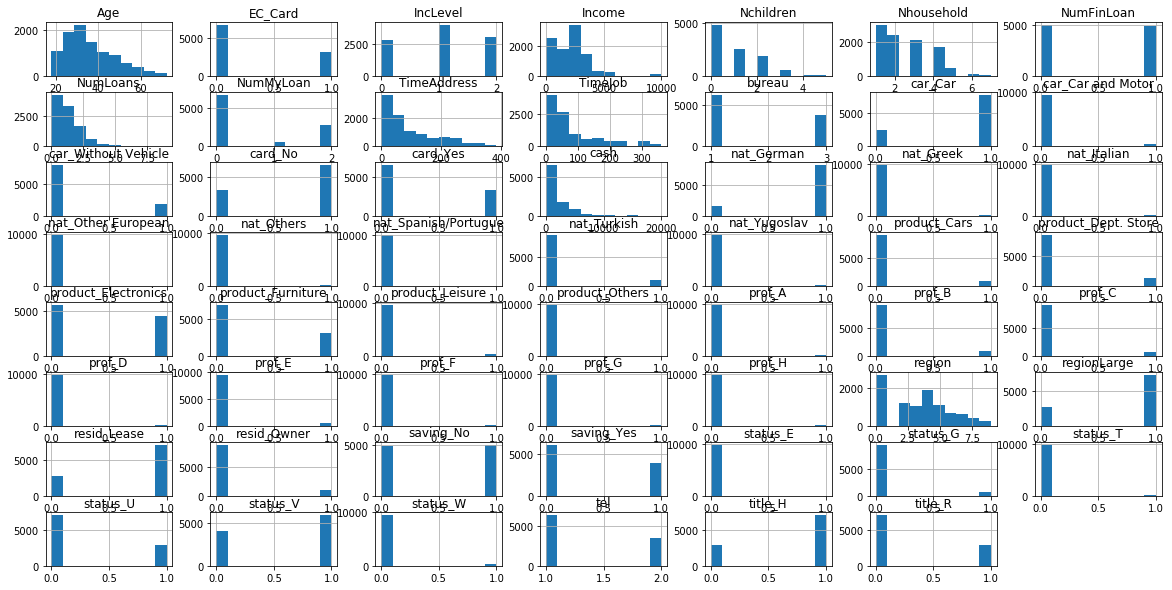

In [15]:
# Visualize Numeric Variable Distributions
data.hist(figsize = (20, 10));

### Begin Modeling <a name="beginModel"></a>

<a name="woe"></a>

<div class="alert alert-info">
<b>Weights of Evidence</b>
</div>

In [16]:
# Load Regression Action Set
conn.loadactionset(actionset='regression')
conn.loadactionset(actionset='dataPreprocess');

NOTE: Added action set 'regression'.
NOTE: Added action set 'dataPreprocess'.


In [17]:
# Set Up Inputs and Target
inputs   = list(data.drop(['target'], axis=1))
target   = 'target'

#### Set up Weights of Evidence Transform

In [18]:
req_packs = []

req_pack1 = dict(name='req1', 
                inputs=inputs,
                targets='target',
                events='Good',
                discretize=dict(method='woe',
                                args = dict(minNBins=3, maxNBins=7)),
                output=dict(scoreWOE=True))

req_packs.append(req_pack1)

In [19]:
# Transform
conn.transform(table=data,
               requestPackages=req_packs, 
               casOut=dict(name='woeTransform', replace=True),
               copyVars = ['target'],
               outVarsNameGlobalPrefix='woe');

In [20]:
# preview Weights Table
conn.CASTable('woeTransform').head(n=5)

,target,woe_Age,woe_bureau,woe_car_Car,woe_car_Car and Motor,woe_car_Without Vehicle,woe_card_No,woe_card_Yes,woe_cash,woe_EC_Card,woe_IncLevel,woe_Income,woe_nat_German,woe_nat_Greek,woe_nat_Italian,woe_nat_Other European,woe_nat_Others,woe_nat_Spanish/Portugue,woe_nat_Turkish,woe_nat_Yugoslav,woe_Nchildren,woe_Nhousehold,woe_NumFinLoan,woe_NumLoans,woe_NumMyLoan,woe_product_Cars,woe_product_Dept. Store,woe_product_Electronics,woe_product_Furniture,woe_product_Leisure,woe_product_Others,woe_prof_A,woe_prof_B,woe_prof_C,woe_prof_D,woe_prof_E,woe_prof_F,woe_prof_G,woe_prof_H,woe_region,woe_regionLarge,woe_resid_Lease,woe_resid_Owner,woe_saving_No,woe_saving_Yes,woe_status_E,woe_status_G,woe_status_T,woe_status_U,woe_status_V,woe_status_W,woe_tel,woe_TimeAddress,woe_TimeJob,woe_title_H,woe_title_R
0,Bad,0.584839,-0.076700,0.303783,0.009406,0.397803,0.259007,0.259007,-0.089127,0.211718,0.424900,0.746486,-0.009907,0.000175,0.006109,-0.008824,-0.014275,0.000684,0.001529,0.006174,-0.269922,-0.337095,-0.122612,-0.031543,0.082077,-0.018178,0.007509,0.106447,0.077063,0.002089,0.002002,-0.001241,0.042856,0.034287,-0.002093,0.030644,0.001296,-0.020719,-0.001327,0.022485,0.052695,-0.044345,0.017728,0.000180,0.000839,-0.000265,0.003193,-0.007108,-0.333001,-0.383359,0.018654,-0.065479,0.077121,0.343187,-0.082372,-0.082372
1,Good,-1.325135,-0.076700,-0.102631,0.009406,-0.109548,-0.662834,-0.662834,-0.137458,-0.572158,0.424900,0.081388,-0.009907,0.000175,0.006109,-0.008824,-0.014275,0.000684,0.001529,0.006174,0.215493,-0.337095,0.112621,-0.031543,0.082077,-0.018178,0.007509,-0.089965,-0.190616,0.002089,0.002002,-0.001241,0.042856,-0.002877,-0.002093,-0.668930,0.001296,-0.020719,-0.001327,0.108428,0.052695,-0.044345,-0.162219,-0.000173,-0.000538,-0.000265,0.003193,-0.007108,-0.333001,-0.383359,0.018654,-0.065479,-0.195166,0.564307,0.031933,0.031933
2,Bad,0.584839,-0.076700,0.303783,0.009406,0.397803,0.259007,0.259007,-0.089127,0.211718,0.424900,0.081388,-0.009907,0.000175,0.006109,-0.008824,-0.014275,0.000684,0.001529,0.006174,-0.269922,-0.299166,0.112621,-0.031543,0.082077,-0.018178,0.007509,-0.089965,0.077063,-0.061733,0.002002,-0.001241,0.042856,-0.002877,-0.002093,0.030644,0.001296,-0.020719,-0.001327,0.022485,0.052695,0.016977,0.017728,-0.000173,-0.000538,-0.000265,0.003193,-0.007108,-0.333001,-0.383359,0.018654,-0.065479,0.430289,-0.011089,0.031933,0.031933
3,Good,-0.409427,0.031128,-0.102631,0.009406,-0.109548,-0.662834,-0.662834,0.045067,0.211718,-0.599895,-0.654010,-0.009907,0.000175,0.006109,-0.008824,-0.014275,0.000684,0.001529,0.006174,0.215493,-0.337095,-0.122612,-0.050909,0.082077,-0.018178,0.007509,-0.089965,-0.190616,0.002089,0.002002,-0.001241,0.042856,-0.002877,-0.002093,0.030644,0.001296,-0.020719,-0.001327,-0.154455,-0.154455,0.016977,0.017728,-0.000173,-0.000538,-0.000265,0.003193,-0.007108,-0.333001,-0.383359,0.018654,0.111910,-0.195166,-0.011089,0.031933,0.031933
4,Good,-0.051227,-0.076700,0.303783,0.009406,0.397803,0.259007,0.259007,-0.089127,0.211718,0.424900,0.215446,-0.009907,0.000175,0.006109,-0.008824,-0.014275,0.000684,0.001529,0.006174,0.215493,-0.337095,0.112621,-0.031543,0.082077,-0.018178,0.007509,-0.089965,-0.190616,0.002089,0.002002,-0.001241,0.042856,-0.002877,-0.002093,0.030644,0.001296,-0.020719,-0.001327,0.108428,0.052695,0.016977,0.017728,-0.000173,-0.000538,-0.000265,0.003193,-0.007108,-0.333001,-0.383359,0.018654,-0.065479,0.054569,-0.011089,-0.082372,-0.082372


<a name="lr"></a>

<div class="alert alert-info">
<b>Logistic Regression</b>
</div>

In [21]:
# Set Empty CAS Table For Model Results
lr_woe_model = conn.CASTable("lr_woe_model",replace = True)

In [22]:
# Concat 'woe_' with Column Names for Inputs
woe_inputs = ['woe_' + str(col)  for col in data.columns[1:]]

# Logistic Regression Model
lr_woe_model = conn.logistic(table = 'woeTransform',
                             model = {'depvar':target,
                                      'effects':woe_inputs},
                             selection = {'method':'FORWARD'},
                             store={'name':'my_lr_Model', 'replace':'true'},
                             output = {'casOut':{'name':'lr_woe_model', 'replace':True},
                                       'copyVars':['target'], 'predprobs':True})

NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Some automatic settings based on memory availability and the size of your problem may slow down your program.  If you have the resources, you can try specifying the PAGEOBS=134520 option to reduce your computation time at the expense of reserving more memory.


In [23]:
# Write Out CAS Table to Pandas Dataframe
woe_out = conn.fetch(table='lr_woe_model', maxrows=len(data), to=len(data))
woe_out_df = pd.DataFrame(woe_out['Fetch'])

woe_out_df.head()

,_PRED_Bad,_PRED_Good,target
0,0.351445,0.648555,Good
1,0.388124,0.611876,Good
2,0.068184,0.931816,Good
3,0.211957,0.788043,Good
4,0.203994,0.796006,Good


In [24]:
# Create 'pred_target' Binary for Confusion Matrix
woe_out_df['pred_target'] = np.where(woe_out_df['_PRED_Good']>0.5, 'Good', 'Bad')

In [25]:
# Confusion Matrix
pd.crosstab(woe_out_df['target'], woe_out_df['pred_target'])

pred_target,Bad,Good
target,,
Bad,52824,261119
Good,31006,1221901


In [26]:
# Score Training Data
woeScore = conn.logisticScore(
            restore='my_lr_Model',
            table='woeTransform',
            fitData='true',
            casOut={'name':'woeScore', 'replace':'true'},
            copyVars=['target'],
            pred='pred',
            resChi='reschi',
            into='into',
            predprobs=True)

In [27]:
# Load Access Action Set for Visualizing and Comparing Models
conn.loadActionSet("percentile");

NOTE: Added action set 'percentile'.


In [28]:
# Run Model Assessment
conn.assess(
    table='woeScore',
    casOut={"name":"woeAssess", "replace":True},
    nbins=100,
    inputs=['predGood'],
    response='target', 
    event='Good', 
    pVar=['predBad'], 
    pEvent='Bad'
);

In [29]:
# Name Score Table and Load it to Pandas Dataframe for Plotting
woeAssess_ROC = conn.CASTable('woeAssess_ROC')
woeAssess_ROC_df = woeAssess_ROC.to_frame()

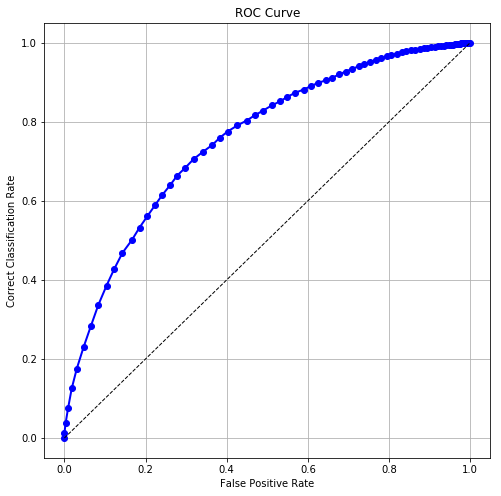

In [30]:
# Plot ROC Curve
plt.figure(figsize=(8,8))
plt.plot(woeAssess_ROC_df._FPR_,woeAssess_ROC_df._Sensitivity_,'bo-',linewidth=2)
plt.plot(pd.Series(range(0,11,1))/10,pd.Series(range(0,11,1))/10,'k--',linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('Correct Classification Rate')
plt.grid(True)
plt.title('ROC Curve')
plt.show()

<a name="deepLearn"></a>

<div class="alert alert-info">
<b>Deep Neural Network</b>
</div>

In [31]:
# Load the Deep Learn Action Set
conn.loadactionset(actionset='deepLearn');

NOTE: Added action set 'deepLearn'.


In [32]:
# Set Up Deep Learning Model Architecture
conn.buildModel(model=dict(name='bankDNN', replace=True), type='DNN')

conn.addlayer(model='bankDNN', name='dataInputs', replace=True,
             layer=dict(type='input', std='STD'))

conn.addlayer(model='bankDNN', name='FC1', replace=True,
             layer=dict(type='FC', act='RECTIFIER', n=32, init='XAVIER'), srcLayers=['dataInputs'])

conn.addlayer(model='bankDNN', name='FC2', replace=True,
             layer=dict(type='FC', act='RECTIFIER', n=32, dropout=0.3, init='XAVIER'), srcLayers=['FC1'])

conn.addLayer(model='bankDNN', name='outLayer', replace=True, 
           layer=dict(type='OUTPUT', n=2, act='LOGISTIC'), srcLayers=['FC2'])

conn.modelInfo(model='bankDNN')

,Descr,Value
0,Model Name,bankdnn
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2


In [33]:
start = time()

# Train Deep Learning Model
out_dnn = conn.dltrain(
                model = 'bankDNN', 
                table = 'woeTransform',
                #validTable = dict(name='dataSample', where='_PartInd_=1.0'),
                nthreads = 2,
                inputs = woe_inputs, 
                target = target,
                modelWeights = {"name":"bankDNNWeights", "replace":True},
                optimizer = dict(
                    miniBatchSize = 32,
                    algorithm = dict(method='ADAM', learningRate=0.001),
                    maxEpochs = 10, 
                    loglevel = 2))
end = time()

print("Deep Learning Train Time: %.2f Seconds" %(end - start))

NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 2914.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.43 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: target
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Good
NOTE:  Level      1: Bad 
NOTE:  Number of input variables:    55
NOTE:  Number of numeric input variables:     55
NOTE:  Epoch           Learning Rate     Loss    Fit Error      Time (s)
NOTE:          0           0.001       0.3015     0.1163         6.59
NOTE:          1           0.001       0.2345     0.0851         5.94
NOTE:          2           0.001       0.2185     0.0786         7.25
NOTE:       

In [34]:
# Model Info with Parameters
out_dnn['ModelInfo']

,Descr,Value
0,Model Name,bankdnn
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,2848
7,Number of Bias Parameters,66
8,Total Number of Model Parameters,2914
9,Approximate Memory Cost for Training (MB),2


<a name="randomForest"></a>

<div class="alert alert-info">
<b>Random Forest Decision Tree</b>
</div>

In [35]:
# Load the Decision Tree Action Set (RF and GB Models)
conn.loadactionset('decisionTree');

NOTE: Added action set 'decisionTree'.


In [36]:
# Create Place Holder for 'rf_model'
rf_model = conn.CASTable("rf_model",replace = True)

In [37]:
start = time()

# Fit Random Forest Model
out_rf = conn.forestTrain(
            table = 'woeTransform', 
            target = target,
            inputs = woe_inputs,
            bootstrap = 0.60,
            crit = "GINI",
            ntree = 500,
            m = 20,
            vote = 'PROB',
            varimp = True, # The importance value is determined by the total Gini reduction.
            oob = True,
            seed = 12345,
            casout = rf_model)

end = time()
print("Random Forest Train Time: %.2f Seconds" %(end - start))

Random Forest Train Time: 220.48 Seconds


In [38]:
# Model Info Including Misclassification Rate
out_rf['ModelInfo']

,Descr,Value
0,Number of Trees,500.000000
1,Number of Selected Variables (M),20.000000
2,Random Number Seed,12345.000000
3,Bootstrap Percentage (%),60.000000
4,Number of Bins,20.000000
5,Number of Variables,55.000000
6,Confidence Level for Pruning,0.250000
7,Max Number of Tree Nodes,63.000000
8,Min Number of Tree Nodes,43.000000
9,Max Number of Branches,2.000000


In [39]:
# Variable Importance
out_rf['DTreeVarImpInfo'].head(n=10)

,Variable,Importance,Std
0,woe_Age,10253.030429,4031.956659
1,woe_status_U,3382.632497,4681.914738
2,woe_card_No,3236.424589,2002.001410
3,woe_card_Yes,2233.395217,2006.460744
4,woe_TimeJob,2147.189716,731.680050
5,woe_status_V,1624.279078,2600.201316
6,woe_Nhousehold,1592.331592,3462.417908
7,woe_Income,1314.575056,931.964238
8,woe_IncLevel,1109.119234,2405.277741
9,woe_TimeAddress,704.008235,445.455295


In [40]:
# Score Data
forestScore = conn.forestscore(
                    modelTable=rf_model,
                    copyVars=['target'],
                    casOut={"name":"forestScored", "replace":True}, 
                    vote='prob',
                    table='woeTransform',
                    encodeName=True)

In [41]:
# Show Score
forestScore['ScoreInfo']

,Descr,Value
0,Number of Observations Read,1566850
1,Number of Observations Used,1566850
2,Misclassification Error (%),19.080192743


<a name="gradientBoost"></a>

<div class="alert alert-info">
<b>Gradient Boosted Decision Tree</b><a name="gradientBoost"></a>
</div>

In [42]:
# Create Place Holder for 'rf_model'
gb_model = conn.CASTable("gb_model",replace = True)

In [43]:
start = time()

# Fit Gradient Boosted Model
out_gb = conn.gbtreeTrain(
            table = 'woeTransform', 
            target = target,
            inputs = woe_inputs,
            binOrder=True,
            maxlevel=8,
            nbins=100,
            nTree=75,
            varImp=True,
            seed = 12345,
            casout = gb_model)

end = time()
print("Gradient Boosting Train Time: %.2f Seconds" %(end - start))

Gradient Boosting Train Time: 74.51 Seconds


In [44]:
# Model Info
out_gb['ModelInfo']

,Descr,Value
0,Number of Trees,75.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),55.0
5,Number of Bins,100.0
6,Number of Variables,55.0
7,Max Number of Tree Nodes,253.0
8,Min Number of Tree Nodes,177.0
9,Max Number of Branches,2.0


In [45]:
# Variable Importance
out_gb['DTreeVarImpInfo'].head(n=10)

,Variable,Importance,Std
0,woe_Age,2204.169382,1208.077728
1,woe_region,1061.358627,162.879703
2,woe_TimeAddress,960.857953,161.276283
3,woe_TimeJob,960.147994,196.012658
4,woe_cash,954.225590,152.717720
5,woe_Income,750.276483,180.627766
6,woe_card_No,673.376118,832.195632
7,woe_NumLoans,637.225352,159.174585
8,woe_Nhousehold,428.003655,152.598694
9,woe_Nchildren,394.230023,168.946016


In [46]:
# Score the Test Data
gbScore = conn.decisionTree.gbtreeScore(
                modelTable = gb_model,
                copyVars = ['target'],
                casOut = {"name":"forestScored", "replace":True},
                table = 'woeTransform',
                encodeName = True)

In [47]:
# Show Score
gbScore['ScoreInfo']

,Descr,Value
0,Number of Observations Read,1566850
1,Number of Observations Used,1566850
2,Misclassification Error (%),8.4952611928
